# demonstration of brownian behaviour
Tim Tyree<br>
9.18.2022

In [1]:
from lib.my_initialization import *
from lib import *
import shutil
%autocall 1
%load_ext autoreload
%autoreload 2

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Automatic calling is: Smart


In [2]:
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [3]:
def comp_time_averaged_msd(df_ranges,DS,DT,
                min_lifetime=200., #ms   # 100. #ms
                crop_start_by=40., #ms
                max_lagtime=1e5,   #ms
                num_bootstrap_samples=100, # 1000,
                detail=False, # True # True performs expensive computation to determine an effective number of observations
                bins='auto',
                min_numobs=None,
                npartitions=None,
                printing=True,**kwargs):
    """df_ranges has fields ['x','y','tdeath','trial_num','annihilation_index']. one trajectory is uniquely identified by fields ['trial_num','annihilation_index'].
    
    Example Usage:
df_msd_creation,df_bootstrapped_creation = comp_time_averaged_msd(
                df_ranges=df_ranges_creation,
                DS=DS,
                DT=DT,
                min_lifetime=200., #ms   # 100. #ms
                crop_start_by=40., #ms
                max_lagtime=1e5,   #ms
                num_bootstrap_samples=100, # 1000,
                npartitions=None,
                detail=False, # True # True performs expensive computation to determine an effective number of observations
                bins='auto')  # ,min_numobs=None,npartitions=None,printing=True,**kwargs)
    """
    groups=df_ranges.groupby(by=['trial_num','annihilation_index'])
    #identify the long-lived particles
    boo_ll = groups['tdeath'].max()>min_lifetime
    group_names_selected = boo_ll[boo_ll].index.values
    df_msd_lst=[]
    num_steps=group_names_selected.shape[0]
    if printing:
        print(f"computing time averaged msd for {num_steps} spiral tip trajectories...")
    assert (num_steps>0)
    for step,(trial_num,pid) in enumerate(group_names_selected):
        g = groups.get_group((trial_num,pid)).sort_values(by='tdeath') #tdeath is used for both df_ranges.
        x_values = g['x'].values
        y_values = g['y'].values
        t_values = g['tdeath'].values
        #unwrap pbc for given trajectory
        xv,yv = unwrap_and_center_xy_values(x_values,y_values,width,height)#,jump_thresh=None,**kwargs)
        boo=t_values>crop_start_by
        frame_values = np.arange(np.sum(boo))
        traj=pd.DataFrame({'x':xv[boo],'y':yv[boo],'frame':frame_values})#,'t':t_values[boo]})
        #compute msd for the first trajectory
        df_msd = trackpy.msd(
            traj,
            mpp=DS,
            fps=fps,
            max_lagtime=max_lagtime,
            detail=detail)
        df_msd.reset_index(drop=True)
        df_msd['trial_num'] = trial_num
        df_msd['annihilation_index']  = pid
        #record
        df_msd_lst.append(df_msd)
        #printProgressBar
        if printing:
            printProgressBar(step + 1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    df_msd = pd.concat(df_msd_lst)
    if printing:
        print(f"\ncomputing bootstrapped mean over {len(df_msd_lst)} spiral tip trajectories...")
    df_bootstrapped=bin_and_bootstrap_xy_values_parallel(
                                   x=df_msd['lagt'].values,
                                   y=df_msd['msd'].values,
                                   xlabel='lagt',
                                   ylabel='msd',
                                   bins=bins,
                                   min_numobs=min_numobs,
                                   num_bootstrap_samples=num_bootstrap_samples, # 1000,
                                   npartitions=npartitions,
                                   use_test=False,test_val=0,printing=False)#,**kwargs)
    return df_msd,df_bootstrapped

In [4]:
def comp_radial_velocities(df_ranges,DT,
            tavg2=14, #ms
            min_minlifetime=40., #ms 200.,# #100.
            min_minrange = 0.2, #cm
            max_tdeath=40., #ms
            num_bootstrap_samples=100, # 1000,
            bins='auto',
            min_numobs=None,
            npartitions=None,
            printing=True,**kwargs):
    """
    Example Usage:
df_dRdt,df_bootstrapped = comp_radial_velocities(df_ranges,DT,
            tavg2=14, #ms
            min_minlifetime=40., #ms 200.,# #100.
            min_minrange = 0.2, #cm
            max_tdeath=40., #ms
            num_bootstrap_samples=100, # 1000,
            bins='auto',
            min_numobs=None,
            npartitions=None,
            printing=True)#,**kwargs)
    """
    tavg2*=1e-3 #s                 
    navg2=int(tavg2/DT)
    fps=np.around (1/DT,  5)
    if not (navg2%2==1): #odd navg2 is required by savgol_filter
        navg2+=1
        tavg2=np.around(navg2*DT,7)

    #compute the xy values
    savgol_kwargs0=dict(window_length=navg2,polyorder=3,
        deriv=0,delta=1.0,axis=-1,mode='interp')
    #compute the xy velocities
    savgol_kwargs1=dict(window_length=navg2,polyorder=3,
        deriv=1,delta=1.0,axis=-1,mode='interp')
    #compute the xy accelerations
    savgol_kwargs2=dict(window_length=navg2,polyorder=3,
        deriv=2,delta=1.0,axis=-1,mode='interp')

    #preallocate memory
#     df_ranges['xRinv']=np.nan
    df_ranges['xR']=np.nan
    df_ranges['vR']=np.nan
#     df_ranges['aR']=np.nan
    #identify particles to be considered
    name_lst=[]
    groups=df_ranges.groupby(by=['trial_num','annihilation_index'])
    for n,g in groups:
        minlifetime = g['tdeath'].max()
        minrange = g['R'].min()
        if (minlifetime>=min_minlifetime)&(minrange<=min_minrange):
            name_lst.append(n)
    if printing:
        print(f"identified {len(name_lst)} annihilation events that look reasonable.")
    num_steps = len(name_lst)

    if printing:
        print(f"computing radial velocities...")
    for step,(trial_num,annihilation_index) in enumerate(name_lst):
        boo = df_ranges['trial_num'] ==trial_num
        boo&= df_ranges['annihilation_index'] ==annihilation_index
        #compute smoothed derivatives
        R_values = df_ranges[boo]['R'] #cm
#         df_ranges.loc[boo,'xRinv'] = savgol_filter(1/R_values,**savgol_kwargs0) #cm
        df_ranges.loc[boo,'xR'] = savgol_filter(R_values,**savgol_kwargs0) #cm
        df_ranges.loc[boo,'vR'] = savgol_filter(R_values,**savgol_kwargs1)*fps #cm per s
#         df_ranges.loc[boo,'aR'] = savgol_filter(R_values,**savgol_kwargs2)*fps**2 #cm per s^2
        #printProgressBar
        if printing:
            printProgressBar(step + 1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)

    #scatter of dRdt versus 1/R
    boo_null = df_ranges['xR'].isnull()
    bootdeath=df_ranges['tdeath']>=max_tdeath
    df_dRdt = df_ranges[(~boo_null)&(~bootdeath)].copy()
    df_dRdt['invR'] = 1/df_dRdt['R'].values
    df_dRdt['dRdt'] = -df_dRdt['vR'].values #orient axes
    
    if printing:
        print(f"\ncomputing bootstrapped mean over {num_steps} spiral tip trajectories...")
    df_bootstrapped=bin_and_bootstrap_xy_values_parallel(
                                   x=df_dRdt['xR'].values,
                                   y=df_dRdt['dRdt'].values,
                                   xlabel='R',
                                   ylabel='dRdt',
                                   bins=bins,
                                   min_numobs=min_numobs,
                                   num_bootstrap_samples=num_bootstrap_samples, # 1000,
                                   npartitions=npartitions,
                                   use_test=False,test_val=0,printing=False)#,**kwargs)
    return df_dRdt,df_bootstrapped

In [5]:
#forked from tbins
def gener_normal_random_perturbations(
        num_iter=100,
        random_state=42,
        use_random_seed=True,
        use_include_original=True,
    **kwargs):
    """default values of loc=0.0, scale=1.0, are can be modified through kwargs

    Example Usage:
rand_values1,rand_values2=gener_normal_random_perturbations(num_iter=100,random_state=42,use_random_seed=True)#,use_include_original=True,**kwargs)
    """
    if use_random_seed:
        np.random.seed(random_state)
    rand_values1=np.random.normal(size=num_iter+1, **kwargs)
    rand_values2=np.random.normal(size=num_iter+1, **kwargs)
    if use_include_original:
        #include the original at the start
        rand_values1[0]*=0.
        rand_values2[0]*=0.
    return rand_values1,rand_values2

# compute the mean squared distance using time averaging on each trajectory after unwrapping periodic boundary conditions

In [6]:
#FK model trajectories
#per 005
annihil_range_dir_fk = f"{nb_dir}/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_annihilation_range_timeseries.pkl"
creation_range_dir_fk = f"{nb_dir}/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl" # 79 trials


# annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_annihilation_range_timeseries.pkl"
# creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl" # 79 trials
DT = 5e-3 # s / frame
#per 001
# annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
# creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_creation_range_timeseries.pkl"
# DT = 1e-3 # s / frame
# DS = 0.0025 # cm / px
DS = 0.025 # cm / px
assert os.path.exists(annihil_range_dir_fk)
assert os.path.exists(creation_range_dir_fk)
data_annihil=load_from_pickle(annihil_range_dir_fk)
data_creation=load_from_pickle(creation_range_dir_fk)

In [7]:
fps=np.around (1/DT,  5)
width=200
height=200

In [8]:
df_ranges_annihiln = pd.concat(data_annihil)
df_ranges_creation = pd.concat(data_creation)

In [9]:
print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")

num. trials in cached annihilation ranges: 79
num. trials in cached creation ranges: 79


In [12]:
#DONE: compute the minimum lifetimes of particles
#DONE: plot the minimum lifetimes of particles

In [149]:
#compute msd for both creation and annihilation
df_msd_creation,df_bootstrapped_creation = comp_time_averaged_msd(
                df_ranges=df_ranges_creation,
                DS=DS,
                DT=DT,
                min_lifetime=200., #ms   # 100. #ms
                crop_start_by=0,#40., #ms
                max_lagtime=1e5,   #ms
                num_bootstrap_samples=100, # 1000,
                npartitions=None,
                detail=False, # True # True performs expensive computation to determine an effective number of observations
                bins='auto')  # ,min_numobs=None,npartitions=None,printing=True,**kwargs)

df_msd_annihiln,df_bootstrapped_annihiln = comp_time_averaged_msd(
                df_ranges=df_ranges_annihiln,
                DS=DS,
                DT=DT,
                min_lifetime=200., #ms   # 100. #ms
                crop_start_by=0,#40., #ms
                max_lagtime=1e5,   #ms
                num_bootstrap_samples=100, # 1000,
                npartitions=None,
                detail=False, # True # True performs expensive computation to determine an effective number of observations
                bins='auto')  # ,min_numobs=None,npartitions=None,printing=True,**kwargs)

computing time averaged msd for 5146 spiral tip trajectories...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
computing bootstrapped mean over 5146 spiral tip trajectories...
computing time averaged msd for 4854 spiral tip trajectories...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
computing bootstrapped mean over 4854 spiral tip trajectories...


In [150]:
#record
dict_msd_fk = dict(df_msd_creation=df_msd_creation,
                   df_bootstrapped_creation=df_bootstrapped_creation,
                   df_msd_annihiln=df_msd_annihiln,
                   df_bootstrapped_annihiln=df_bootstrapped_annihiln
                  )

In [43]:
#LR model trajectories
#per 001
annihil_range_dir_lr = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
creation_range_dir_lr = f"{nb_dir}/Data/from_wjr/positions_lr//200x200/tippos_per_001_creation_range_timeseries.pkl"
assert os.path.exists(annihil_range_dir_lr)
assert os.path.exists(creation_range_dir_lr)


In [152]:
#TODO: wrap this cell to foo.  pass it over a list of folders to measure Area-law dependence of apparent D of spiral tips.
DS = 0.025 # cm / px
# DS = 0.0025 # cm / px
DT = 1e-3 # s / frame
fps=np.around (1/DT,  5)
width=200
height=200
data_annihil=load_from_pickle(annihil_range_dir_lr)
data_creation=load_from_pickle(creation_range_dir_lr)
df_ranges_annihiln = pd.concat(data_annihil)
df_ranges_creation = pd.concat(data_creation)
print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")

#compute msd for both creation and annihilation
df_msd_creation,df_bootstrapped_creation = comp_time_averaged_msd(
                df_ranges=df_ranges_creation,
                DS=DS,
                DT=DT,
                min_lifetime=100., #ms   # 100. #ms
                crop_start_by=0,#40., #ms
                max_lagtime=1e5,   #ms
                num_bootstrap_samples=100, # 1000,
                npartitions=None,
                detail=False, # True # True performs expensive computation to determine an effective number of observations
                bins='auto')  # ,min_numobs=None,npartitions=None,printing=True,**kwargs)

df_msd_annihiln,df_bootstrapped_annihiln = comp_time_averaged_msd(
                df_ranges=df_ranges_annihiln,
                DS=DS,
                DT=DT,
                min_lifetime=100., #ms   # 100. #ms
                crop_start_by=0,#40., #ms
                max_lagtime=1e5,   #ms
                num_bootstrap_samples=100, # 1000,
                npartitions=None,
                detail=False, # True # True performs expensive computation to determine an effective number of observations
                bins='auto')  # ,min_numobs=None,npartitions=None,printing=True,**kwargs)

#record
dict_msd_lr= dict(df_msd_creation=df_msd_creation,
                   df_bootstrapped_creation=df_bootstrapped_creation,
                   df_msd_annihiln=df_msd_annihiln,
                   df_bootstrapped_annihiln=df_bootstrapped_annihiln
                  )

num. trials in cached annihilation ranges: 640
num. trials in cached creation ranges: 638
computing time averaged msd for 896 spiral tip trajectories...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
computing bootstrapped mean over 896 spiral tip trajectories...
computing time averaged msd for 1189 spiral tip trajectories...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
computing bootstrapped mean over 1189 spiral tip trajectories...


In [153]:
# msd_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd.pkl"
msd_dir_lr = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd.pkl"
# msd_dir_lr = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd_uncropped.pkl"
# msd_dir_lr = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd_uncropped_abstracted_units.pkl"
save_to_pickle(msd_dir_lr,dict_msd_lr)
print(f"{msd_dir_lr=}")

msd_dir_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd.pkl'


In [154]:
# msd_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/fk200x200/tippos_per_c_001_msd.pkl"
# msd_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_c_005_msd.pkl"

msd_dir_fk = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_c_005_msd.pkl"
# msd_dir_fk = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_c_005_msd_uncropped.pkl"
# msd_dir_fk = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_c_005_msd_uncropped_abstracted_units.pkl"
save_to_pickle(msd_dir_fk,dict_msd_fk)
print(f"{msd_dir_fk=}")

msd_dir_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_c_005_msd.pkl'


# DONE: plot time averaged MSD computed via Fourier method described in Ref. 1

Ref. 1:
- DOI: 10.1051/sfn/201112010
- https://www.neutron-sciences.org/articles/sfn/abs/2011/01/sfn201112010/sfn201112010.html

In [50]:
# msd_dir_fk

In [11]:
# msd_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd.pkl"
# msd_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_c_005_msd.pkl"
msd_dir_lr = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_msd.pkl"
# msd_dir_fk = f"{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_c_005_msd.pkl" #<< note: per_c was used in wj's fk tips
msd_dir_fk = f"{nb_dir}/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_msd.pkl"
dict_msd_lr = load_from_pickle(msd_dir_lr)
dict_msd_fk = load_from_pickle(msd_dir_fk)

yscale=1e0

#extract the xy values for either of the full models
df = dict_msd_fk['df_bootstrapped_annihiln']
# df = dict_msd_fk['df_bootstrapped_creation']
x_values_fk = df['lagt'].values
y_values_fk = df['msd'].values
Delta_y_values_fk = df['Delta_msd'].values

#extract the xy values for either of the full models
df = dict_msd_lr['df_bootstrapped_annihiln']
# df = dict_msd_lr['df_bootstrapped_creation']
x_values_lr = df['lagt'].values
y_values_lr = df['msd'].values
Delta_y_values_lr = df['Delta_msd'].values

y_values_fk*=yscale**2
Delta_y_values_fk*=yscale**2
y_values_lr*=yscale**2
Delta_y_values_lr*=yscale**2


In [12]:
#powerlaw fits of msd versus t in a range that looks reasonable 
# xmin_fk=0.01
# xmax_fk=10
xmin_fk=0.1
xmax_fk=4
# xmax_fk=3
# xmax_fk=1
boo=(x_values_fk>=xmin_fk)&(x_values_fk<xmax_fk)
print(f"(Fenton-Karma) msd powerlaw fit of msd from lagt={xmin_fk} to {xmax_fk}:")
dict_fit_fk = print_fit_power_law(x=x_values_fk[boo],y=y_values_fk[boo])
D_fk = dict_fit_fk['M']/4
Delta_D_fk = dict_fit_fk['Delta_M']/4
print(f"D = {D_fk:.4f} +/- {Delta_D_fk:.4f} cm^2/s")

xmin_lr=0.02
# xmin_lr=0.06
# xmin_lr=0.1
# xmax_lr=0.1
xmax_lr=0.2
# xmax_lr=0.3
boo=(x_values_lr>=xmin_lr)&(x_values_lr<xmax_lr)
print(f"\n(Luo-Rudy) msd powerlaw fit of msd from lagt={xmin_lr} to {xmax_lr}:")
dict_fit_lr = print_fit_power_law(x=x_values_lr[boo],y=y_values_lr[boo])
D_lr = dict_fit_lr['M']/4
Delta_D_lr = dict_fit_lr['Delta_M']/4
print(f"D = {D_lr:.4f} +/- {Delta_D_lr:.4f} cm^2/s")

(Fenton-Karma) msd powerlaw fit of msd from lagt=0.1 to 4:
m = 1.001574 +/- 0.012169
M = 0.601874 +/- 0.004858 Hz/cm^2; B=0.602354 +/- 0.008501
RMSE=0.1207 Hz/cm^2; R^2=0.9930; MPE=10.1104%; N=186
D = 0.1505 +/- 0.0012 cm^2/s

(Luo-Rudy) msd powerlaw fit of msd from lagt=0.02 to 0.2:
m = 0.995682 +/- 0.019039
M = 16.334743 +/- 1.080847 Hz/cm^2; B=16.533842 +/- 0.174579
RMSE=0.0574 Hz/cm^2; R^2=0.9940; MPE=3.9124%; N=65
D = 4.0837 +/- 0.2702 cm^2/s


In [13]:
#GOAL: dev mvp figure for fig. 2a re: the slope of the autocorrelation function at long time scales is brownian
#DONE: add 95% CI
#DONE: compute expected brownian values / i.e. D = slope / 4
#DONE: verified brownian motion agrees with D = slope / 4
#DONE: choose reasonable min/max for powerlaw fit equivalent brownian values
#TODO: plot expected brownian values plus offset to show msd is parallel with brownian at some point...
#TODO(optionally, if ^that all remains sus...): crop the janky ending
#TODO: recompute msd for lr using longer lived particles
#  Q: does ^this make straighter for longer?

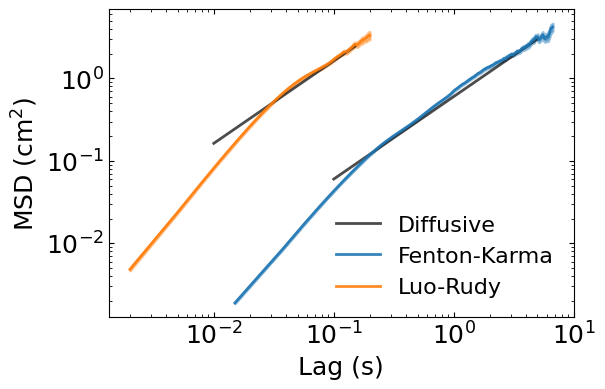

In [14]:
#plot the values on a log-log plot along with an ideal brownian particle of equal diffusion coefficient#TODO: plot expected brownian values plus offset to show msd is parallel with brownian at some point...
lw=2
alpha=0.9
fontsize=18
use_loglog=True
#check if msd=0 at lagt=0
fig,ax=plt.subplots(figsize=(6,4))

#plot expected brownian values plus offset to show msd is parallel with brownian at some point...
xv1=np.linspace(0.01,0.15,10)
xv2=np.linspace(0.1,5,10)
ax.plot(xv1,dict_fit_lr['M']*xv1+0.,'k-',lw=2,alpha=0.7,label='Diffusive')
# ax.plot(xv1,dict_fit_lr['M']*xv1+0.,'k-',lw=2,alpha=0.7)
ax.plot(xv2,dict_fit_fk['M']*xv2+0.,'k-',lw=2,alpha=0.7)

#plot the full models
ax.plot(x_values_fk,y_values_fk,c='C0',lw=lw,alpha=alpha,label='Fenton-Karma')
ax.fill_between(x_values_fk,y_values_fk-Delta_y_values_fk,y_values_fk+Delta_y_values_fk,color='C0',lw=lw,alpha=alpha/2)
boo=x_values_lr<=xmax_lr
ax.plot(x_values_lr[boo],y_values_lr[boo],c='C1',lw=lw,alpha=alpha,label='Luo-Rudy')
ax.fill_between(x_values_lr[boo],y_values_lr[boo]-Delta_y_values_lr[boo],y_values_lr[boo]+Delta_y_values_lr[boo],color='C1',lw=lw,alpha=alpha/2)

# ax.plot(x_values_lr,y_values_lr,c='C1',lw=lw,alpha=alpha,label='Luo-Rudy')
# ax.fill_between(x_values_lr,y_values_lr-Delta_y_values_lr,y_values_lr+Delta_y_values_lr,color='C1',lw=lw,alpha=alpha/2)
# ax.set_ylim((1.0178650359332904e-05, 0.14507306398356945))

#format_plot
format_plot(ax=ax,xlabel='Lag (s)',ylabel=r'MSD (cm$^2$)',fontsize=fontsize,use_loglog=use_loglog)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False)
plt.show()
# ax.get_ylim()

In [19]:
# #DONE: period scratchwork
# period_fk_hat = 105.3 / 0.9082 # (1.6/ 0.9082) ms  
# Delta_period_fk_hat = 1.7 / 0.9082
# # number of particles considered with at least 1 loop: 12368
# period_lr_hat = 33.37/ 0.3427 # (73/ 0.3427) ms / 0.3427
# Delta_period_lr_hat = 0.73/ 0.3427
# # number of particles considered: 29402
# print(f"{period_fk_hat=:.4f} +/- {Delta_period_fk_hat:.4f} ms")
# print(f"{period_lr_hat=:.4f} +/- {Delta_period_lr_hat:.4f} ms")
#>>> yielded
# period_fk_hat=115.9436 +/- 1.8718 ms
# period_lr_hat=97.3738 +/- 2.1301 ms

# TODO: make supplemental plots showing region of parameters where slope is not significantly different from linear

In [550]:
def resample_linearly(x_values,y_values,dt=0.001):
    '''compute the linearly interpolated time series at a regular interval of dt
    Example Usage:
x_values,y_values=resample_linearly(x_values,y_values,dt=0.001)
    '''
    tau_values_interpolated=np.arange(x_values.min(),x_values.max(),dt)
    sd_values_interpolated=np.interp(x=tau_values_interpolated, xp=x_values, fp=y_values, left=None, right=None, period=None)
    return tau_values_interpolated, sd_values_interpolated

In [565]:
# nrows=160
nrows=40
x_values=x_values_fk.copy()
y_values=y_values_fk.copy()
# x_values=x_values_lr.copy()
# y_values=y_values_lr.copy()

In [566]:
# x_values,y_values=resample_linearly(x_values,y_values,dt=0.001)

In [567]:
xmax=0.2
# xmax=0.9
ymin=1
ymax=10.25
# ymax=20.25
extent=0.005,xmax,ymin,ymax
#powerlaw fits of msd versus t in a range that looks reasonable 
xmin_values = np.linspace(0.005,xmax,nrows)
xmax_values = np.linspace(ymin,ymax,nrows)
# xmin_values = np.logspace(-3,-1,nrows)
# xmax_values = np.logspace(0,1,nrows)
exp_img=np.zeros((nrows,nrows))
Delta_exp_img=np.zeros((nrows,nrows))

In [568]:
for i,xmin in enumerate(xmin_values):
    for j,xmax in enumerate(xmax_values):
        boo=(x_values>=xmin)&(x_values<xmax)
        B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=x_values[boo],y=y_values[boo])
        #record
        exp_img[i,j]=m
        Delta_exp_img[i,j]=Delta_m

In [569]:
boo_linear_img= ((exp_img-Delta_exp_img)<=1.)&((exp_img+Delta_exp_img)>=1.)
boo_linear_img.sum(),nrows**2
# exp_img

(196, 1600)

In [570]:
# ax.imshow?

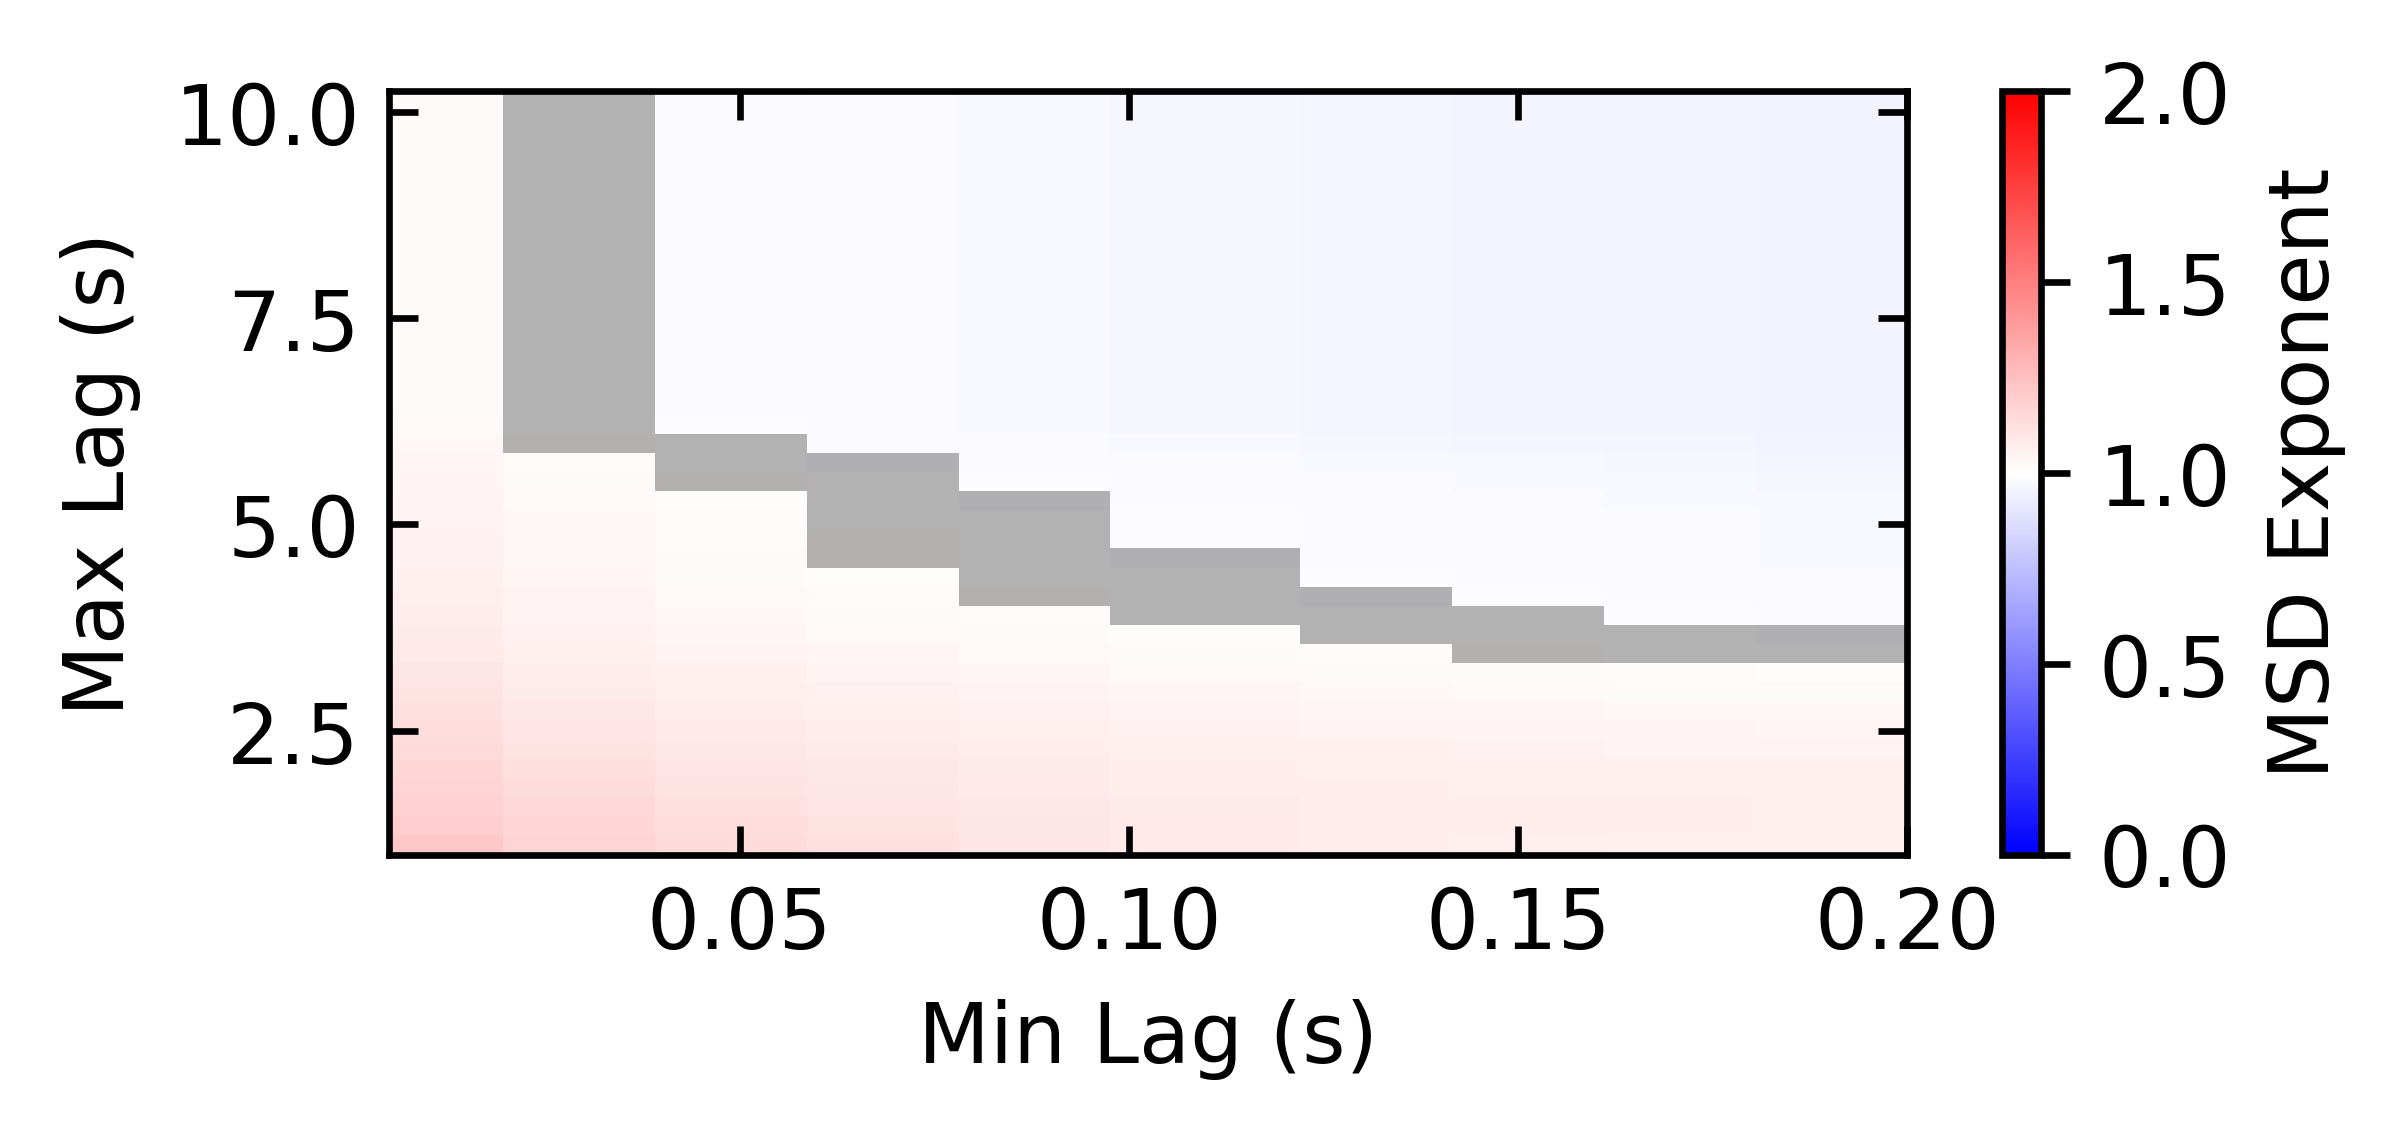

In [571]:
fig,ax=plt.subplots(figsize=(4,2),dpi=600)
im=ax.imshow(exp_img.T,extent=extent,aspect='auto',vmin=0,vmax=2,cmap='bwr',origin='lower')
ax.imshow(boo_linear_img.T,'gray_r',extent=extent,aspect='auto',alpha=0.3,origin='lower')
fig.colorbar(im, ax=ax,label='MSD Exponent')#,labelsize=15)
format_plot(ax=ax,xlabel='Min Lag (s)',ylabel='Max Lag (s)',fontsize=10)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
# plt.ylim([ymin,ymax-0.7])
plt.show()

In [572]:
# nrows=160
nrows=40
x_values=x_values_lr.copy()
y_values=y_values_lr.copy()

In [573]:
# x_values,y_values=resample_linearly(x_values,y_values,dt=0.00001)

In [574]:
# xmax=0.05
xmax=0.03
# xmax=0.06
ymin=0.06
# ymin=0.05
ymax=0.4
# ymax=0.5
# ymax=0.3
# x_values,y_values=resample_linearly(x_values,y_values,dt=0.001)
extent=0.005,xmax,ymin,ymax
# extent=ymin,ymax,0.005,xmax
#powerlaw fits of msd versus t in a range that looks reasonable 
xmin_values = np.linspace(0.005,xmax,nrows)
xmax_values = np.linspace(ymin,ymax,nrows)

In [575]:
# xmin_values = np.logspace(-3,-1,nrows)
# xmax_values = np.logspace(0,1,nrows)
exp_img=np.zeros((nrows,nrows))
Delta_exp_img=np.zeros((nrows,nrows))

for i,xmin in enumerate(xmin_values):
    for j,xmax in enumerate(xmax_values):
        boo=(x_values>=xmin)&(x_values<=xmax)
        B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=x_values[boo],y=y_values[boo])
        #record
        exp_img[i,j]=m
        Delta_exp_img[i,j]=Delta_m

boo_linear_img= ((exp_img-Delta_exp_img)<=1.)&((exp_img+Delta_exp_img)>=1.)
# boo_linear_img.sum(),nrows**2

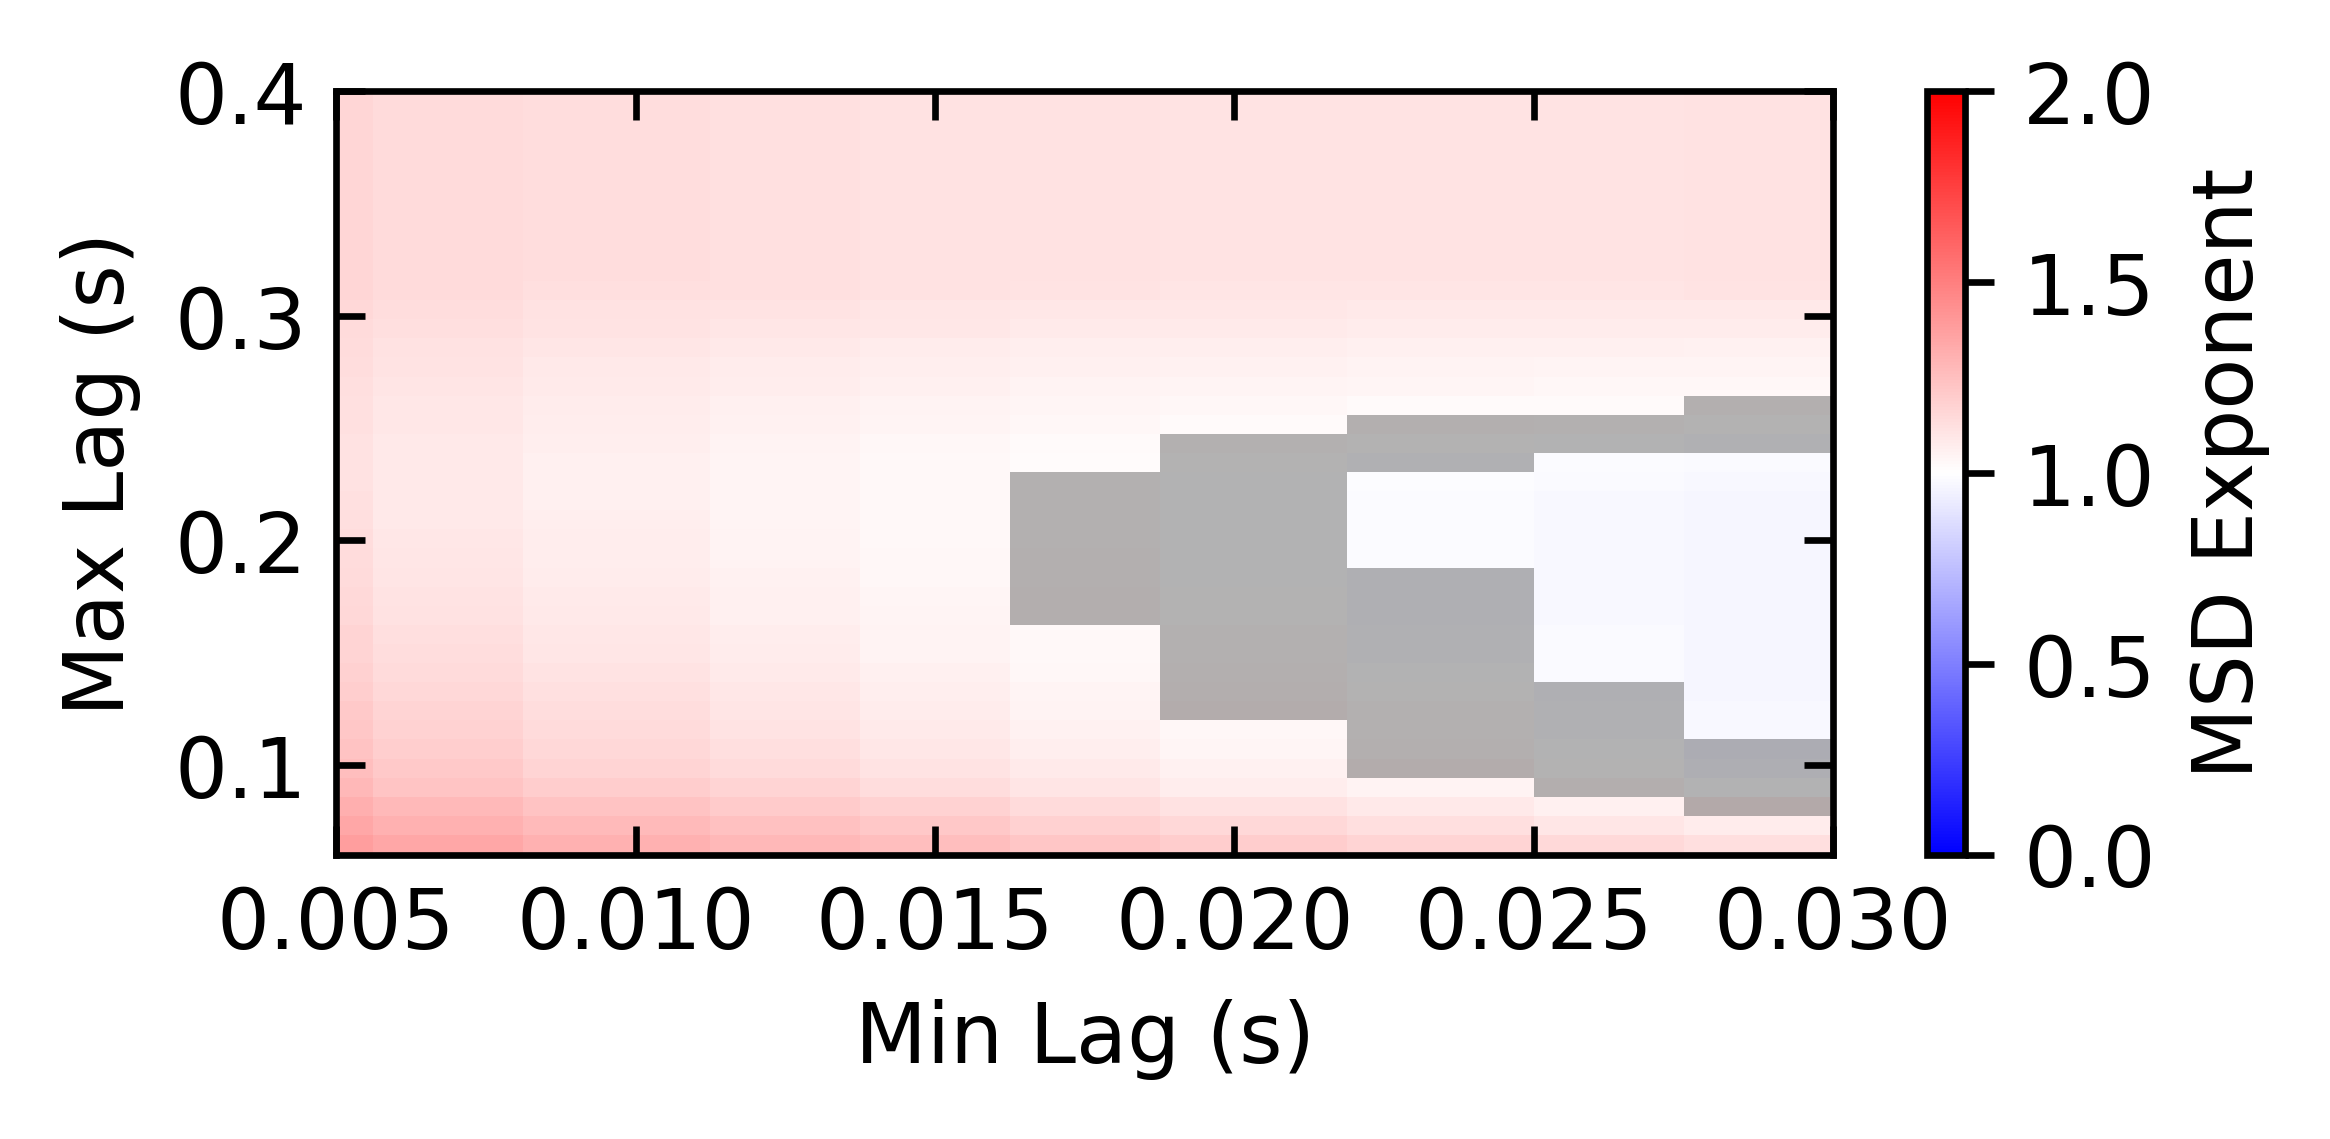

In [576]:
fig,ax=plt.subplots(figsize=(4,2),dpi=600)
im=ax.imshow(exp_img.T,extent=extent,aspect='auto',vmin=0,vmax=2,cmap='bwr',origin='lower')
ax.imshow(boo_linear_img.T,'gray_r',extent=extent,aspect='auto',alpha=0.3,origin='lower')
fig.colorbar(im, ax=ax,label='MSD Exponent')#,labelsize=15)
format_plot(ax=ax,xlabel='Min Lag (s)',ylabel='Max Lag (s)',fontsize=10)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.tight_layout()
# plt.savefig()
# plt.ylim([ymin,ymax-0.115])
plt.show()

## DONE: control estimation of D for pure diffusion process samples

In [96]:
#DONE: find how i generated a matrix of normal random variables in neurophysics / in tbins
#DONE: generate M brownian random walk with N steps 
num_iter=40000
# random_state=42
# random_state=43
random_state=44
use_random_seed=True
Dinput=1. #cm^2/s
DT=1. #s
stepsize=np.sqrt(2*Dinput*DT) #cm
rand_values1,rand_values2=gener_normal_random_perturbations(num_iter=num_iter,random_state=random_state,use_random_seed=use_random_seed)#,use_include_original=True,**kwargs)
#integrate Wiener process
x_values = stepsize*np.cumsum(rand_values1)
y_values = stepsize*np.cumsum(rand_values2)
frame_values = np.arange(num_iter+1)


In [97]:
traj=pd.DataFrame({'x':x_values,'y':y_values,'frame':frame_values})


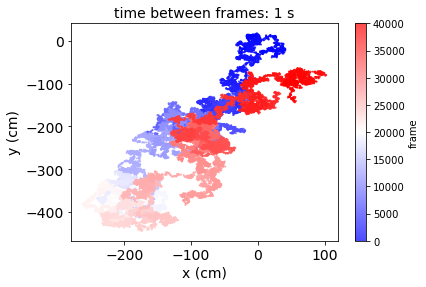

In [98]:
#plot the final trajectory
fig,ax=plt.subplots()
traj.plot.scatter(x='x',y='y',c='frame',vmin=0,vmax=num_iter+1,s=1,alpha=0.7,ax=ax,cmap='bwr')
format_plot(ax=ax,xlabel='x (cm)', ylabel='y (cm)',fontsize=14)
plt.title(f'time between frames: {DT:.0f} s',fontsize=14)
plt.show()

In [102]:
#DONE: compute the MSD from the FFT method used in fig. 2a
#TODO: check I'm not stupidly putting in the wrong units when I use trackpy.msd above
#Q: is it a mistake that I am passing DS the distance between pixels, mpp?
# Q: <--> is x in units of length or pixels in the above? 
#compute msd for the first trajectory
DS=1.
num_digits_round=7
# detail=False
detail=True
max_lagtime=int(DT*num_iter)
fps=np.around(1/DT,num_digits_round)
df_msd = trackpy.msd(
    traj,
    mpp=DS,
    fps=fps,
    max_lagtime=max_lagtime,
    detail=detail)
df_msd.head()


,<x>,<y>,<x^2>,<y^2>,msd,N,lagt
lagt,,,,,,,
1,0.001359,-0.003578,2.000784,1.983703,3.984488,40000.000000,1.0
2,0.002701,-0.007153,4.030176,3.992175,8.022351,26666.222224,2.0
3,0.004034,-0.010695,6.040061,6.022178,12.062239,18946.720226,3.0
4,0.005378,-0.014263,8.063749,8.085351,16.149100,14544.694222,4.0
5,0.006754,-0.017828,10.083432,10.142158,20.225591,11763.875443,5.0


In [100]:
#compute expected
xv=DT*np.arange(num_iter)
yv=4*Dinput*DT*np.arange(num_iter)
tmax=(np.max(xv)+DT)/60

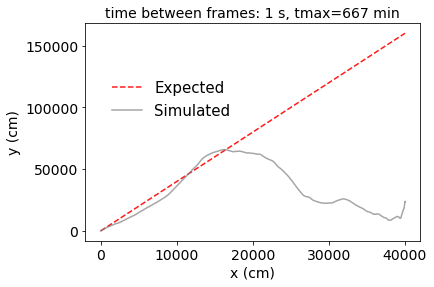

In [101]:
fig,ax=plt.subplots()

#TODO: plot msd expected
ax.plot(xv,yv,'r--',alpha=0.9,label='Expected')

#TODO: plot msd of this trajectory
df_msd.plot(x='lagt',y='msd',c='gray',#c='N',#vmin=0,vmax=num_iter+1,s=1,
                    alpha=0.7,ax=ax, label='Simulated')#,cmap='bwr')

#format_plot
format_plot(ax=ax,xlabel='x (cm)', ylabel='y (cm)',fontsize=14)
AddLegend(ax=ax,xy=(0.04,0.8))
# ax.legend(loc='upper left')#,fancybox=False)
plt.title(f'time between frames: {DT:.0f} s, {tmax=:.0f} min',fontsize=14)
plt.show()

#TODO: estimate the slope by ols

#TODO: compute Doutput

#TODO: compare to expected value Dinput

#TODO: print the effective number of observations that trackpy offers to return...

In [69]:
AddLegend

<function lib.viewer.bluf.LegendPlot.AddLegend(ax=None, xy=(1.04, 1.04), fontsize=15, loc='upper left', frameon=False, **kwargs)>

In [ ]:
# g = groups.get_group((trial_num,pid)).sort_values(by='tdeath') #tdeath is used for both df_ranges.
# x_values = g['x'].values
# y_values = g['y'].values
# t_values = g['tdeath'].values
# #unwrap pbc for given trajectory
# xv,yv = unwrap_and_center_xy_values(x_values,y_values,width,height)#,jump_thresh=None,**kwargs)
# boo=t_values>crop_start_by
# frame_values = np.arange(np.sum(boo))
# traj=pd.DataFrame({'x':xv[boo],'y':yv[boo],'frame':frame_values})#,'t':t_values[boo]})


# demonstration of attractive behavior, which deviates from the brownian behavior

## old notes on the parameter settings i eventually decided on...


In [20]:
tavg1=4#8#4 #moving average window, in ms

# tavg2=12#24 #ms #savgol_filter time window performed on R 
tavg2=24# #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
# tavg2=10.# #ms #savgol_filter time window performed on R  #12 ms was no longer smooth

#particle model token trajectories
# # #neighbors=0
# input_fn_lst = [
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_0_L_10_kappa_0_varkappa_0/Log/pbc_particle_log1_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_0_varkappa_0/Log/pbc_particle_log5_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_0/Log/pbc_particle_log5_log.csv',
#     '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log5_log.csv'
# ]


# # #neighbors=1
# input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log2_log.csv' 
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'  
# # # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'


#two particle control with diffusion
input_fn_lst = [
    '/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0.7_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log1_log.csv'
]

#choose a file for initialization/testing 
input_fn=input_fn_lst[-1]
print(input_fn)
#choose parameters
pid_col='pid_explicit'
width=10
ds=10. #cm for the whole domain
tmin=0.
c='C3'


##########################
# Perform Averaging
##########################
tavg1=0
tavg2=14#todo 0
#one token trajectory file for the fenton karma model and the luo-rudy model
input_fn_lst=[
    # c='C0'
    # #token FK at DT=0.4 (src: TT)
    "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv",
    # c='C1'
    # #tokenLR at DT=0.5 (src: TT)
    "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv",   
]

kwargs_particle=dict(
        max_dtmax_thresh=0,  #ms
        max_Rfinal_thresh=0.2,  #cm
        min_duration_thresh=15,  #ms
        npartitions=10,#None,
        width=10,
        height=10,
        ds=10,
        use_drop_shorter_than=False,
        drop_shorter_than=0,  #ms
        tmin=0.,  #ms
        pid_col='pid_explicit',
        t_col='t',
        npartitions2=1,
        printing=True)

kwargs_full=dict(
        max_dtmax_thresh = 0,      #ms
        max_Rfinal_thresh = 0.2,   #cm
        min_duration_thresh = 40,  #ms
        npartitions=None,
        width=200,
        height=200,
        ds=5,
        use_drop_shorter_than=True,
        drop_shorter_than=40, #ms
        tmin=100., #ms
        pid_col='particle',
        t_col='t',
        npartitions2=1,
        printing=True)


/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/neighbors_1_uniformic_0_fc_2_r_0.1_D_0.7_L_10_kappa_1500_varkappa_5_N_2/Log/pbc_particle_log1_log.csv


## load the range timeseries from the full models

In [21]:
#LR model trajectories
#per 001
annihil_range_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
creation_range_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr//200x200/tippos_per_001_creation_range_timeseries.pkl"
# annihil_range_dir_lr = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
# creation_range_dir_lr = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr//200x200/tippos_per_001_creation_range_timeseries.pkl"
assert os.path.exists(annihil_range_dir_lr)
assert os.path.exists(creation_range_dir_lr)
# DS = 0.0025 # cm / px
DT = 1e-3 # s / frame
data_annihil=load_from_pickle(annihil_range_dir_lr)
data_creation=load_from_pickle(creation_range_dir_lr)
df_ranges_annihiln = pd.concat(data_annihil)
df_ranges_creation = pd.concat(data_creation)
print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")
#TODO: dev dRdt routine
#TODO: eval dRdt routine
# #TODO: record
# dict_dRdt_lr= dict(df_dRdt_creation=df_dRdt_creation,
#                    df_bootstrapped_creation=df_bootstrapped_creation,
#                    df_dRdt_annihiln=df_dRdt_annihiln,
#                    df_bootstrapped_annihiln=df_bootstrapped_annihiln
#                   )

num. trials in cached annihilation ranges: 640
num. trials in cached creation ranges: 638


In [22]:
bins=np.linspace(1e-6,3,50)
kwargs_dRdt=dict(tavg2=14, #ms
            min_minlifetime=40,#100.,#200.,#40., #ms  #
            min_minrange = 0.2, #cm
            max_tdeath=100.,#200.,#40., #ms
            num_bootstrap_samples=100, # 1000,
            bins=bins, #'auto',
            min_numobs=None,npartitions=None,printing=True)


In [23]:
use_cache=True
if not use_cache:
    #sort by particle and then by time
    df_ranges=df_ranges_annihiln\
        .sort_values(by=['trial_num','annihilation_index','tdeath'])
    df_ranges.reset_index(inplace=True)
    df_dRdt_annihiln,df_bootstrapped_annihiln = comp_radial_velocities(df_ranges,DT,**kwargs_dRdt)
    df_ranges=df_ranges_creation\
        .sort_values(by=['trial_num','annihilation_index','tdeath'])
    df_ranges.reset_index(inplace=True)
    df_dRdt_creation,df_bootstrapped_creation = comp_radial_velocities(df_ranges,DT,**kwargs_dRdt)
    #record
    dict_dRdt_lr= dict(df_dRdt_creation=df_dRdt_creation,
                       df_bootstrapped_creation=df_bootstrapped_creation,
                       df_dRdt_annihiln=df_dRdt_annihiln,
                       df_bootstrapped_annihiln=df_bootstrapped_annihiln
                      )

In [24]:
#FK model trajectories
# #per 005
# annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_annihilation_range_timeseries.pkl"
# creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl" # 79 trials
# DT = 5e-3 # s / frame
#per 001
# annihil_range_dir_fk = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
# creation_range_dir_fk = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_creation_range_timeseries.pkl"
annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_creation_range_timeseries.pkl"
DT = 1e-3 # s / frame
# DS = 0.0025 # cm / px
assert os.path.exists(annihil_range_dir_fk)
assert os.path.exists(creation_range_dir_fk)
data_annihil=load_from_pickle(annihil_range_dir_fk)
data_creation=load_from_pickle(creation_range_dir_fk)
df_ranges_annihiln = pd.concat(data_annihil)
df_ranges_creation = pd.concat(data_creation)
print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")
#TODO: dev dRdt routine
#TODO: eval dRdt routine
# #TODO: record
# dict_dRdt_fk= dict(df_dRdt_creation=df_dRdt_creation,
#                    df_bootstrapped_creation=df_bootstrapped_creation,
#                    df_dRdt_annihiln=df_dRdt_annihiln,
#                    df_bootstrapped_annihiln=df_bootstrapped_annihiln
#                   )

num. trials in cached annihilation ranges: 79
num. trials in cached creation ranges: 79


In [25]:
kwargs_dRdt=dict(tavg2=14, #ms
            min_minlifetime=200.,#ms  # #40.,  takes forever to run... 
            min_minrange = 0.2, #cm
            max_tdeath=100.,#200.,#40., #ms
            num_bootstrap_samples=100, # 1000,
            bins=bins, #'auto',
            min_numobs=None,npartitions=None,printing=True)
if not use_cache:

    #sort by particle and then by time
    df_ranges=df_ranges_annihiln\
        .sort_values(by=['trial_num','annihilation_index','tdeath'])
    df_ranges.reset_index(inplace=True)
    df_dRdt_annihiln,df_bootstrapped_annihiln = comp_radial_velocities(df_ranges,DT,**kwargs_dRdt)
    df_ranges=df_ranges_creation\
        .sort_values(by=['trial_num','annihilation_index','tdeath'])
    df_ranges.reset_index(inplace=True)
    df_dRdt_creation,df_bootstrapped_creation = comp_radial_velocities(df_ranges,DT,**kwargs_dRdt)
    #record
    dict_dRdt_fk= dict(df_dRdt_creation=df_dRdt_creation,
                       df_bootstrapped_creation=df_bootstrapped_creation,
                       df_dRdt_annihiln=df_dRdt_annihiln,
                       df_bootstrapped_annihiln=df_bootstrapped_annihiln
                      )

## plot from cache

In [26]:
def print_fit_ols(x,y,printing=True):
    """print_fit_power_law prints fit to power law by ordinary least squares (ols).
    Delta_... indicates the radial distance to the 95% CI resulting from ols.
    print_fit_power_law returns a dictionary of floats with the following schema:

    schema:
        m: exponent
        M: magnitude
        B: y-intercept
        rmse: root mean squared error
        Rsq: R squared
        num_obs: number of observations

    Example Usage:
dict_fit = print_fit_ols(x,y,printing=True)
    """
    dict_fit=compute_95CI_ols(x,y)
    yhat=dict_fit['b']+dict_fit['m']*x
    rmse=np.sqrt(np.mean((yhat-y)**2))
    num_obs = x.shape[0]
    #record
    dict_fit['num_obs'] = num_obs
    dict_fit['rmse'] = rmse
    dict_fit['Rsq'] = dict_fit['Rsquared'] #alias
    if printing:
        print_dict(dict_fit)
    return dict_fit

In [27]:
# use_cache=True
if use_cache:
#     dRdt_dir_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_radial_velocities.pkl'
#     dRdt_dir_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_radial_velocities.pkl'
    dRdt_dir_fk='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_radial_velocities.pkl'
    dRdt_dir_lr='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_radial_velocities.pkl'
    dict_dRdt_fk = load_from_pickle(dRdt_dir_fk)
    dict_dRdt_lr = load_from_pickle(dRdt_dir_lr)

In [28]:
#attempt to measure a reasonable value for the attraction coefficient
df_bootstrapped_lr=dict_dRdt_lr['df_bootstrapped_annihiln']
x_values_lr = 1/df_bootstrapped_lr['R'].values
y_values_lr = df_bootstrapped_lr['dRdt'].values
Delta_y_values_lr = df_bootstrapped_lr['Delta_dRdt'].values

df_bootstrapped_fk=dict_dRdt_fk['df_bootstrapped_annihiln']
x_values_fk = 1/df_bootstrapped_fk['R'].values
y_values_fk = df_bootstrapped_fk['dRdt'].values
Delta_y_values_fk = df_bootstrapped_fk['Delta_dRdt'].values

In [29]:
xmin_fk=0.0
# xmax_fk=3
# xmin_fk=3
xmax_fk=10
boo=(x_values_fk>=xmin_fk)&(x_values_fk<xmax_fk)
print(f"\n(Fenton-Karma) linear fit of dRdt from 1/R={xmin_fk} to {xmax_fk}:")
dict_fit_fk = print_fit_ols(x=x_values_fk[boo],y=y_values_fk[boo],printing=True)
ahat_fk = -dict_fit_fk['m']/2
Delta_ahat_fk = dict_fit_fk['Delta_m']/2
print(f"ahat = {ahat_fk:.4f} +/- {Delta_ahat_fk:.4f} cm^2/s")

xmin_lr=0.0
# xmax_lr=3
# xmin_lr=3
xmax_lr=10
boo=(x_values_lr>=xmin_lr)&(x_values_lr<xmax_lr)
print(f"\n(Luo-Rudy) linear fit of dRdt from 1/R={xmin_lr} to {xmax_lr}:")
dict_fit_lr = print_fit_ols(x=x_values_lr[boo],y=y_values_lr[boo],printing=True)
ahat_lr = -dict_fit_lr['m']/2
Delta_ahat_lr = dict_fit_lr['Delta_m']/2
print(f"ahat = {ahat_lr:.4f} +/- {Delta_ahat_lr:.4f} cm^2/s")


(Fenton-Karma) linear fit of dRdt from 1/R=0.0 to 10:
m=-4.550823917522961
Delta_m=0.8299672832720622
b=-0.7883724177008169
Delta_b=1.5044154352605568
Rsquared=0.7674370424368964
num_obs=37
rmse=3.1625294434003433
Rsq=0.7674370424368964
ahat = 2.2754 +/- 0.4150 cm^2/s

(Luo-Rudy) linear fit of dRdt from 1/R=0.0 to 10:
m=-8.087927742495596
Delta_m=0.4593631505563615
b=-2.310333356275457
Delta_b=0.7439196689530453
Rsquared=0.9635892116333213
num_obs=47
rmse=1.8623782485431748
Rsq=0.9635892116333213
ahat = 4.0440 +/- 0.2297 cm^2/s


In [30]:
xmin_lr=0.0
# xmax_lr=3
# xmin_lr=3
xmax_lr=10
boo=(x_values_lr>=xmin_lr)&(x_values_lr<xmax_lr)
print(f"\n(Luo-Rudy) msd linear fit of dRdt from 1/R={xmin_lr} to {xmax_lr}:")
dict_fit_lr = print_fit_ols(x=x_values_lr[boo],y=y_values_lr[boo],printing=True)
ahat_lr = -dict_fit_lr['m']/2
Delta_ahat_lr = dict_fit_lr['Delta_m']/2
print(f"ahat = {ahat_lr:.4f} +/- {Delta_ahat_lr:.4f} cm^2/s")


(Luo-Rudy) msd linear fit of dRdt from 1/R=0.0 to 10:
m=-8.087927742495596
Delta_m=0.4593631505563615
b=-2.310333356275457
Delta_b=0.7439196689530453
Rsquared=0.9635892116333213
num_obs=47
rmse=1.8623782485431748
Rsq=0.9635892116333213
ahat = 4.0440 +/- 0.2297 cm^2/s


In [31]:
# print(f"Fenton-Karma fit:")
# # boo = 
# # dict_fit_fk = print_fit_ols(x=x_values_fk[boo],y=y_values_fk[boo],printing=True)
# # dict_fit_fk = print_fit_ols(x=x_values_fk,y=y_values_fk,printing=True)

# print(f"\nLuo-Rudy fit:")
# dict_fit_lr = print_fit_ols(x=x_values_lr[boo],y=y_values_lr[boo],printing=True)
# # dict_fit_lr = print_fit_ols(x=x_values_lr,y=y_values_lr,printing=True)


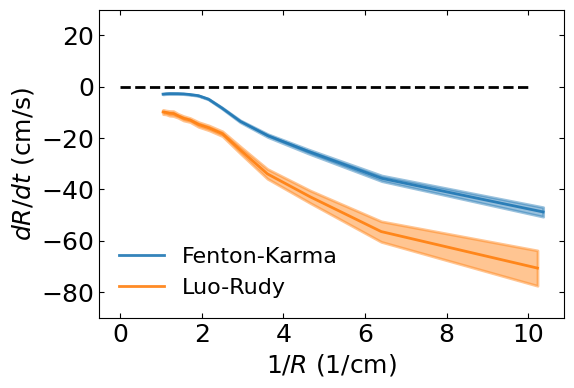

In [33]:
#plot the values on a log-log plot along with an ideal brownian particle of equal diffusion coefficient#TODO: plot expected brownian values plus offset to show msd is parallel with brownian at some point...
lw=2
alpha=0.9
fontsize=18
use_loglog=True
#check if msd=0 at lagt=0
fig,ax=plt.subplots(figsize=(6,4))

#plot the full models results
xmin=1
boofk=x_values_fk>=xmin
boolr=x_values_lr>=xmin
ax.plot(x_values_fk[boofk],y_values_fk[boofk],c='C0',lw=lw,alpha=alpha,label='Fenton-Karma')
ax.fill_between(x_values_fk[boofk],y_values_fk[boofk]-Delta_y_values_fk[boofk],y_values_fk[boofk]+Delta_y_values_fk[boofk],color='C0',lw=lw,alpha=alpha/2)
ax.plot(x_values_lr[boolr],y_values_lr[boolr],c='C1',lw=lw,alpha=alpha,label='Luo-Rudy')
ax.fill_between(x_values_lr[boolr],y_values_lr[boolr]-Delta_y_values_lr[boolr],
                y_values_lr[boolr]+Delta_y_values_lr[boolr],color='C1',lw=lw,alpha=alpha/2)

#TODO: plot ols fits and print the apparent attraction coefficients

# # ax.set_ylim((1.0178650359332904e-05, 0.14507306398356945))
# #plot expected values plus offset to show msd is parallel with brownian at some point...
# xv=np.linspace(0.0,10,100)
# ax.plot(xv,dict_fit_lr['m']*xv+dict_fit_lr['b'],'k-',lw=2,alpha=0.7)
# ax.plot(xv,dict_fit_fk['m']*xv+dict_fit_fk['b'],'k-',lw=2,alpha=0.7)
# # ax.plot(xv,dict_fit_lr['m']*xv+0.,'r-',lw=2,alpha=0.7)
# # ax.plot(xv,dict_fit_fk['m']*xv+0.,'k-',lw=2,alpha=0.7)

xv1=np.linspace(0.01,10,10)
ax.plot(xv1,xv1*0.,'k--',lw=2,alpha=1.)


#format_plot
format_plot(ax, xlabel=r'$1/R$ (1/cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False)
ax.set_ylim([-90,30])
plt.show()
# ax.get_ylim()

In [43]:
#TODO: attempt to measure a reasonable value for the attraction coefficient
df_bootstrapped_lr_dagger=dict_dRdt_lr['df_bootstrapped_creation']
x_values_lr_dagger = 1/df_bootstrapped_lr_dagger['R'].values
y_values_lr_dagger = -df_bootstrapped_lr_dagger['dRdt'].values
Delta_y_values_lr_dagger = df_bootstrapped_lr_dagger['Delta_dRdt'].values

df_bootstrapped_fk_dagger=dict_dRdt_fk['df_bootstrapped_creation']
x_values_fk_dagger = 1/df_bootstrapped_fk_dagger['R'].values
y_values_fk_dagger = -df_bootstrapped_fk_dagger['dRdt'].values
Delta_y_values_fk_dagger = df_bootstrapped_fk_dagger['Delta_dRdt'].values

In [44]:
xmin_fk=0.0
# xmax_fk=3
# xmin_fk=3
xmax_fk=10
boo=(x_values_fk_dagger>=xmin_fk)&(x_values_fk_dagger<xmax_fk)
print(f"\n(Fenton-Karma) linear fit of dRdt from 1/R={xmin_fk} to {xmax_fk}: (Creation)")
dict_fit_fk = print_fit_ols(x=x_values_fk_dagger[boo],y=y_values_fk_dagger[boo],printing=True)
ahat_fk = dict_fit_fk['m']/2
Delta_ahat_fk = dict_fit_fk['Delta_m']/2
print(f"ahat = {ahat_fk:.4f} +/- {Delta_ahat_fk:.4f} cm^2/s")

xmin_lr=0.0
# xmax_lr=3
# xmin_lr=3
xmax_lr=10
boo=(x_values_lr_dagger>=xmin_lr)&(x_values_lr_dagger<xmax_lr)
print(f"\n(Luo-Rudy) linear fit of dRdt from 1/R={xmin_lr} to {xmax_lr}: (Creation)")
dict_fit_lr = print_fit_ols(x=x_values_lr_dagger[boo],y=y_values_lr_dagger[boo],printing=True)
ahat_lr = dict_fit_lr['m']/2
Delta_ahat_lr = dict_fit_lr['Delta_m']/2
print(f"ahat = {ahat_lr:.4f} +/- {Delta_ahat_lr:.4f} cm^2/s")


(Fenton-Karma) linear fit of dRdt from 1/R=0.0 to 10: (Creation)
m=9.310993680303415
Delta_m=0.8278023935479061
b=-1.6016969018476477
Delta_b=1.3694108517449324
Rsquared=0.9187170630749573
num_obs=45
rmse=3.3253649701370316
Rsq=0.9187170630749573
ahat = 4.6555 +/- 0.4139 cm^2/s

(Luo-Rudy) linear fit of dRdt from 1/R=0.0 to 10: (Creation)
m=9.474432100893113
Delta_m=1.138208466888485
b=6.313476423148073
Delta_b=1.8646119645784094
Rsquared=0.858146734918594
num_obs=46
rmse=4.600352216339196
Rsq=0.858146734918594
ahat = 4.7372 +/- 0.5691 cm^2/s


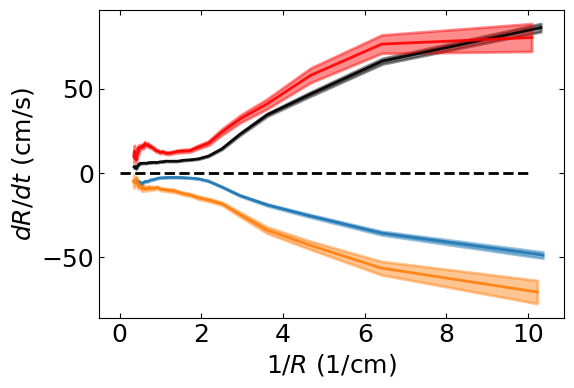

In [47]:
#plot the values on a log-log plot along with an ideal brownian particle of equal diffusion coefficient#TODO: plot expected brownian values plus offset to show msd is parallel with brownian at some point...
lw=2
alpha=0.9
fontsize=18
use_loglog=True
#check if msd=0 at lagt=0
fig,ax=plt.subplots(figsize=(6,4))

#plot the full models results
ax.plot(x_values_fk,y_values_fk,c='C0',lw=lw,alpha=alpha,label='Fenton-Karma (Annihilation)')
ax.fill_between(x_values_fk,y_values_fk-Delta_y_values_fk,y_values_fk+Delta_y_values_fk,color='C0',lw=lw,alpha=alpha/2)
ax.plot(x_values_lr,y_values_lr,c='C1',lw=lw,alpha=alpha,label='Luo-Rudy (Annihilation)')
ax.fill_between(x_values_lr,y_values_lr-Delta_y_values_lr,y_values_lr+Delta_y_values_lr,color='C1',lw=lw,alpha=alpha/2)

#plot the dagger of the full models results
ax.plot(x_values_fk_dagger,y_values_fk_dagger,c='k',lw=lw,alpha=alpha,label='Fenton-Karma (Creation)')
ax.fill_between(x_values_fk_dagger,y_values_fk_dagger-Delta_y_values_fk_dagger,y_values_fk_dagger+Delta_y_values_fk_dagger,color='k',lw=lw,alpha=alpha/2)
ax.plot(x_values_lr_dagger,y_values_lr_dagger,c='r',lw=lw,alpha=alpha,label='Luo-Rudy (Creation)')
ax.fill_between(x_values_lr_dagger,y_values_lr_dagger-Delta_y_values_lr_dagger,y_values_lr_dagger+Delta_y_values_lr_dagger,color='r',lw=lw,alpha=alpha/2)


#TODO(later): plot ols fits and print the apparent attraction coefficients

# ax.set_ylim((1.0178650359332904e-05, 0.14507306398356945))
# #plot expected brownian values plus offset to show msd is parallel with brownian at some point...
# xv2=np.linspace(0.1,5,10)
xv1=np.linspace(0.01,10,10)
ax.plot(xv1,xv1*0.,'k--',lw=2,alpha=1.)
# ax.plot(xv2,dict_fit_fk['M']*xv2+0.,'k-',lw=2,alpha=0.7)


#format_plot
format_plot(ax, xlabel=r'$1/R$ (1/cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.tick_params(top=True, right=True,direction='in',which='both')
# ax.legend(fontsize=fontsize-2,frameon=False)
ax.legend(fontsize=fontsize-2,frameon=False,loc=(1.04,0.3))
plt.show()
# ax.get_ylim()

In [46]:
saving=False
if saving:
    #both as pickles
    dRdt_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_radial_velocities.pkl"
    save_to_pickle(dRdt_dir_fk,dict_dRdt_fk)
    print(f"{dRdt_dir_fk=}")

    dRdt_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_radial_velocities.pkl"
    save_to_pickle(dRdt_dir_lr,dict_dRdt_lr)
    print(f"{dRdt_dir_lr=}")

In [616]:
# fig,ax=plt.subplots()
# # df_bootstrapped_fk.plot.scatter(x='R',y='dRdt',c='C0',s=20,alpha=0.7,ax=ax)
# # df_bootstrapped_lr.plot.scatter(x='R',y='dRdt',c='C1',s=20,alpha=0.7,ax=ax)
# df_bootstrapped_annihiln.plot.scatter(x='R',y='dRdt',c='k',s=20,alpha=0.7,ax=ax)
# df_bootstrapped_creation.plot.scatter(x='R',y='dRdt',c='C1',s=20,alpha=0.7,ax=ax)
# format_plot(ax=ax,xlabel=r'$R$ (cm)',ylabel=r'$dR/dt$ (cm/s)')
# plt.show()

In [621]:
# bins=np.linspace(1e-6,3,50)
# kwargs_dRdt=dict(tavg2=14, #ms
#             min_minlifetime=200.,#40., #ms  #100.
#             min_minrange = 0.2, #cm
#             max_tdeath=200.,#40., #ms
#             num_bootstrap_samples=100, # 1000,
#             bins=bins, #'auto',
#             min_numobs=None,npartitions=None,printing=True)

# #sort by particle and then by time
# df_ranges=df_ranges_annihiln\
#     .sort_values(by=['trial_num','annihilation_index','tdeath'])
# df_ranges.reset_index(inplace=True)
# df_dRdt_annihiln,df_bootstrapped_annihiln = comp_radial_velocities(df_ranges,DT,**kwargs_dRdt)
# df_ranges=df_ranges_creation\
#     .sort_values(by=['trial_num','annihilation_index','tdeath'])
# df_ranges.reset_index(inplace=True)
# df_dRdt_creation,df_bootstrapped_creation = comp_radial_velocities(df_ranges,DT,**kwargs_dRdt)
# #record
# dict_dRdt_fk= dict(df_dRdt_creation=df_dRdt_creation,
#                    df_bootstrapped_creation=df_bootstrapped_creation,
#                    df_dRdt_annihiln=df_dRdt_annihiln,
#                    df_bootstrapped_annihiln=df_bootstrapped_annihiln
#                   )

## DONE: plot the boostrapped average $dR/dt$ versus $1/R$

In [557]:
dRdt_dir_fk='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_radial_velocities.pkl'
dRdt_dir_lr='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_radial_velocities.pkl'
#TODO: plot ^that as potential final produce
#TODO(failing ^that): try increasing tavg2 to 24 ms...

In [588]:
#extract the xy values for either of the full models
dict_dRdt_fk = load_from_pickle(dRdt_dir_fk)
df = dict_dRdt_fk['df_bootstrapped_annihiln']
# df = dict_dRdt_fk['df_bootstrapped_creation']
x_values_fk = df['invR'].values
y_values_fk = df['dRdt'].values
Delta_y_values_fk = df['Delta_dRdt'].values

#extract the xy values for either of the full models
dict_dRdt_lr = load_from_pickle(dRdt_dir_lr)
df = dict_dRdt_lr['df_bootstrapped_annihiln']
# df = dict_dRdt_lr['df_bootstrapped_creation']
x_values_lr = df['invR'].values
y_values_lr = df['dRdt'].values
Delta_y_values_lr = df['Delta_dRdt'].values

In [591]:
# df_dRdt=dict_dRdt_fk['df_dRdt_annihiln']
# df_dRdt.head()

In [596]:
# df_dRdt=dict_dRdt_fk['df_bootstrapped_creation']
# #scatter of dRdt versus 1/R
# boo_null = df_ranges['xR'].isnull()
# bootdeath=df_ranges['tdeath']>=max_tdeath
# df_dRdt = df_ranges[(~boo_null)&(~bootdeath)].copy()
# df_dRdt['invR'] = 1/df_dRdt['R'].values
# df_dRdt['dRdt'] = df_dRdt['vR'].values #orient axes
# if printing:
#     print(f"\ncomputing bootstrapped mean over {num_steps} spiral tip trajectories...")

df_dRdt=dict_dRdt_lr['df_dRdt_annihiln']
bins=np.linspace(1e-6,3,50)
df_bootstrapped_lr=bin_and_bootstrap_xy_values_parallel(
#                                x=df_dRdt['invR'].values,
#                                x=1./df_dRdt['xR'].values,
                               x=df_dRdt['xR'].values,
                               y=-df_dRdt['dRdt'].values, # minus bc correcting sign for time inversion...
                               xlabel='R',
                               ylabel='dRdt',
                               bins=bins)

df_dRdt=dict_dRdt_fk['df_dRdt_annihiln']
bins=np.linspace(1e-6,3,50)
df_bootstrapped_fk=bin_and_bootstrap_xy_values_parallel(
#                                x=df_dRdt['invR'].values,
#                                x=1./df_dRdt['xR'].values,
                               x=df_dRdt['xR'].values,
                               y=-df_dRdt['dRdt'].values, # minus bc correcting sign for time inversion...
                               xlabel='R',
                               ylabel='dRdt',
                               bins=bins)
#                                min_numobs=min_numobs,
#                                num_bootstrap_samples=num_bootstrap_samples, # 1000,
#                                npartitions=npartitions,
#                                use_test=False,test_val=0,printing=False)#,**kwargs)
# return df_dRdt,df_bootstrapped

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/st

In [600]:
#TODO: dev mvp for fig. 2c NOW!
#TODO: remake dRdt bootstrapped traces using t=24 ms smoothing time and with maxt before death set to 200 ms instead of 40 ms

True

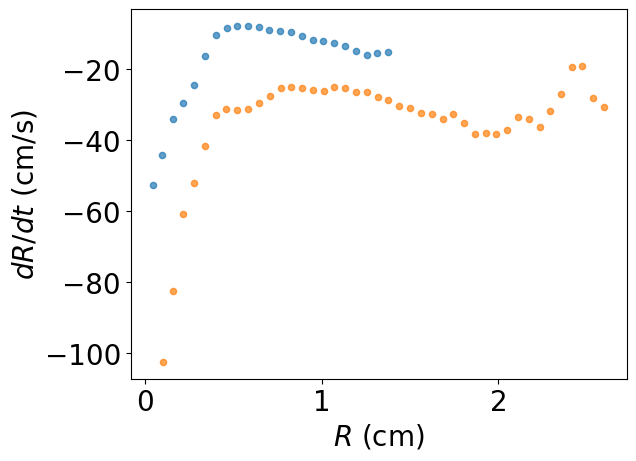

In [601]:
fig,ax=plt.subplots()
df_bootstrapped_fk.plot.scatter(x='R',y='dRdt',c='C0',s=20,alpha=0.7,ax=ax)
df_bootstrapped_lr.plot.scatter(x='R',y='dRdt',c='C1',s=20,alpha=0.7,ax=ax)
format_plot(ax=ax,xlabel=r'$R$ (cm)',ylabel=r'$dR/dt$ (cm/s)')

In [595]:
# df_bootstrapped.plot.scatter(x='invR',y='dRdt',c='k',s=20,alpha=0.7)

In [582]:
# Q: why am i gettings dRdt > 0?
dRdt

NameError: name 'dRdt' is not defined

- TODO(failing ^that): rerun with 1/R smoothed by savgol

In [556]:
#powerlaw fits of dRdt versus invR in a range that looks reasonable 
xmin_fk=0.
xmax_fk=100
boo=(x_values_fk>=xmin_fk)&(x_values_fk<xmax_fk)
dict_fit_fk = print_fit_power_law(x=x_values_fk[boo],y=y_values_fk[boo])
# print(f"(Fenton-Karma) msd powerlaw fit of msd from lagt={xmin_fk} to {xmax_fk}:")
# dict_fit_fk = print_fit_power_law(x=x_values_fk[boo],y=y_values_fk[boo])
# D_fk = dict_fit_fk['M']/4
# Delta_D_fk = dict_fit_fk['Delta_M']/4
# print(f"D = {D_fk:.4f} +/- {Delta_D_fk:.4f} cm^2/s")

xmin_lr=0.0
xmax_lr=100.
# dict_fit_lr = print_fit_power_law(x=x_values_lr,y=y_values_lr)
boo=(x_values_lr>=xmin_lr)&(x_values_lr<xmax_lr)
# print(f"\n(Luo-Rudy) msd powerlaw fit of msd from lagt={xmin_lr} to {xmax_lr}:")
dict_fit_lr = print_fit_power_law(x=x_values_lr[boo],y=y_values_lr[boo])
# D_lr = dict_fit_lr['M']/4
# Delta_D_lr = dict_fit_lr['Delta_M']/4
# print(f"D = {D_lr:.4f} +/- {Delta_D_lr:.4f} cm^2/s")


m = 0.573007 +/- 0.020248
M = 8.265974 +/- 0.952421 Hz/cm^2; B=39.888093 +/- 2.382492
RMSE=15.2114 Hz/cm^2; R^2=0.8044; N=750
m = nan +/- nan
M = nan +/- nan Hz/cm^2; B=nan +/- nan
RMSE=nan Hz/cm^2; R^2=nan; N=476


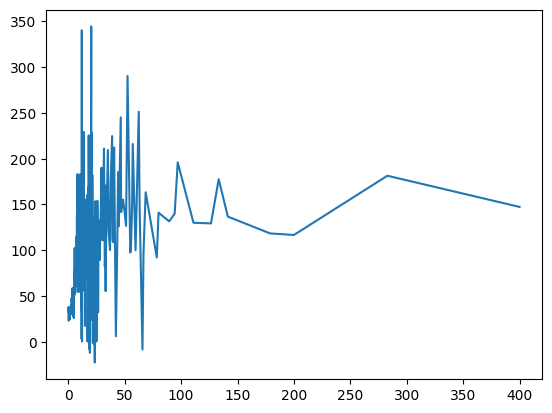

In [551]:
plt.plot(x_values_lr,y_values_lr)

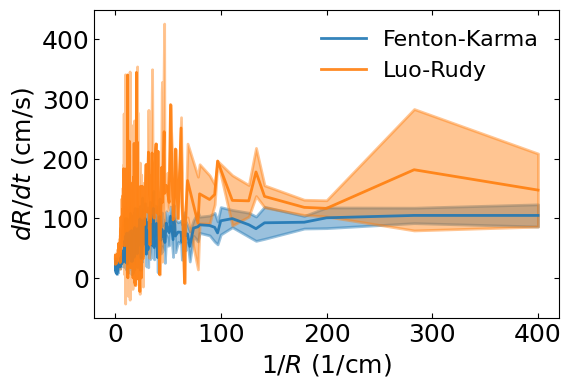

In [539]:
#plot the values on a log-log plot along with an ideal brownian particle of equal diffusion coefficient#TODO: plot expected brownian values plus offset to show msd is parallel with brownian at some point...
lw=2
alpha=0.9
fontsize=18
use_loglog=True
#check if msd=0 at lagt=0
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(x_values_fk,y_values_fk,c='C0',lw=lw,alpha=alpha,label='Fenton-Karma')
ax.fill_between(x_values_fk,y_values_fk-Delta_y_values_fk,y_values_fk+Delta_y_values_fk,color='C0',lw=lw,alpha=alpha/2)
ax.plot(x_values_lr,y_values_lr,c='C1',lw=lw,alpha=alpha,label='Luo-Rudy')
ax.fill_between(x_values_lr,y_values_lr-Delta_y_values_lr,y_values_lr+Delta_y_values_lr,color='C1',lw=lw,alpha=alpha/2)
# ax.set_ylim((1.0178650359332904e-05, 0.14507306398356945))
# #plot expected brownian values plus offset to show msd is parallel with brownian at some point...
# xv1=np.linspace(0.01,0.5,10)
# xv2=np.linspace(0.1,5,10)
# ax.plot(xv1,dict_fit_lr['M']*xv1+0.,'k-',lw=2,alpha=0.7)
# ax.plot(xv2,dict_fit_fk['M']*xv2+0.,'k-',lw=2,alpha=0.7)
#format_plot
format_plot(ax, xlabel=r'$1/R$ (1/cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False)
plt.show()
# ax.get_ylim()

In [ ]:
# #plot a few particle events
# fontsize=14
# fig,ax=plt.subplots(figsize=(7,4))

# #TODO: recreate fig. 2C


# format_plot(ax, xlabel=r'$1/R$ (1/cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
# ax.legend(fontsize=fontsize-2)
# plt.tight_layout()
# plt.show()

## DONE: perform smoothing to compute dRdt. 
- DONE: scatter plot points
- DONE: bootstrap the mean versus 1/R

In [496]:
# DS=5/200 #cm per pixel
tavg2=14 #ms
# DT=1. #ms
tavg2*=1e-3
width=200. #px
height=200. #px
min_minlifetime=40. #ms
navg2=int(tavg2/DT)
fps=np.around (1/DT,  5)
if not (navg2%2==1): #odd navg2 is required by savgol_filter
    navg2+=1
    tavg2=np.around(navg2*DT,7)
navg2

15

In [497]:
#sort by particle and then by time
# df_ranges=df_ranges_creation
df_ranges=df_ranges_annihiln\
    .sort_values(by=['trial_num','annihilation_index','tdeath'])#.reset_index()
df_ranges.reset_index(inplace=True)
# df_ranges.reset_index(inplace=True)
# df_ranges.sort_values(by=['trial_num','annihilation_index','tdeath'],inplace=True)

In [499]:
min_minrange = 0.2 #cm
min_minlifetime = 40. #ms

In [498]:
#compute the xy values
savgol_kwargs0=dict(window_length=navg2,polyorder=3,
    deriv=0,delta=1.0,axis=-1,mode='interp')
#compute the xy velocities
savgol_kwargs1=dict(window_length=navg2,polyorder=3,
    deriv=1,delta=1.0,axis=-1,mode='interp')
#compute the xy accelerations
savgol_kwargs2=dict(window_length=navg2,polyorder=3,
    deriv=2,delta=1.0,axis=-1,mode='interp')

In [500]:
df_ranges['R'].max() #cm

3.5196457563226446

In [501]:
#preallocate memory
df_ranges['xRinv']=np.nan
df_ranges['xR']=np.nan
df_ranges['vR']=np.nan
df_ranges['aR']=np.nan
#identify particles to be considered
name_lst=[]
groups=df_ranges.groupby(by=['trial_num','annihilation_index'])
for n,g in groups:
    minlifetime = g['tdeath'].max()
    minrange = g['R'].min()
#     if minrange>min_minrange:
#         print(f"Warning: minrange>min_minrange for {n}")
    if (minlifetime>=min_minlifetime)&(minrange<=min_minrange):
        name_lst.append(n)
        #gg = g#.sort_values(by='tdeath') # >> ~10% slowdown for fixing inordinal edge case solved by .sort_values(by=['trial_num','annihilation_index','tdeath'])#.reset_index()
print(f"identified {len(name_lst)} annihilation events that look reasonable.")



identified 17088 annihilation events that look reasonable.


In [504]:
print(f"computing radial velocities...")
# for (trial_num,annihilation_index) in name_lst:
for (trial_num,annihilation_index) in np.array(name_lst)[:200]:
    boo = df_ranges['trial_num'] ==trial_num
    boo&= df_ranges['annihilation_index'] ==annihilation_index
    #compute smoothed derivatives
    R_values = df_ranges[boo]['R'] #cm
    df_ranges.loc[boo,'xRinv'] = savgol_filter(1/R_values,**savgol_kwargs0) #cm
    df_ranges.loc[boo,'xR'] = savgol_filter(R_values,**savgol_kwargs0) #cm
    df_ranges.loc[boo,'vR'] = savgol_filter(R_values,**savgol_kwargs1)*fps #cm per s
    df_ranges.loc[boo,'aR'] = savgol_filter(R_values,**savgol_kwargs2)*fps**2 #cm per s^2

computing radial velocities...


In [505]:
#heretim
#scatter plot dRdt versus 1/R
boo_null = df_ranges['xR'].isnull()
df_dRdt = df_ranges[~boo_null].copy()
# df_dRdt['invR'] = 1/df_dRdt['xR'].values
df_dRdt['invR'] = 1/df_dRdt['R'].values
df_dRdt['dRdt'] = df_dRdt['vR'].values #orient axes
# df_dRdt['dRdt'] = 1/df_dRdt['aR'].values
# Rinv_values = 1/df_dRdt['xR'].values
# dRdt_values = df_dRdt['vR'].values
# dRdt2_values = df_dRdt['aR'].values

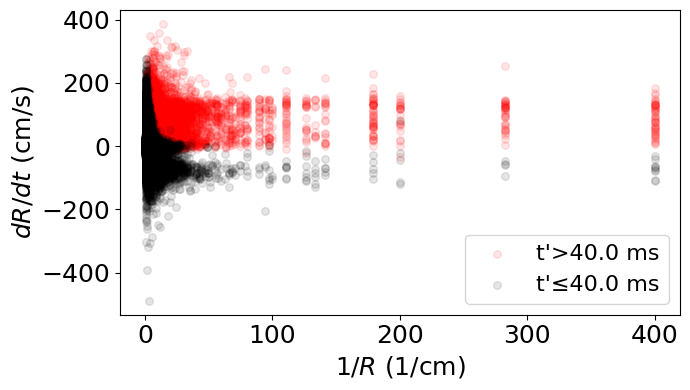

In [506]:
xlim=[0,3]
ylim=[-75,50]
max_tdeath=40. #ms
alpha=0.1
fig,ax=plt.subplots(figsize=(7,4))
bootdeath=df_dRdt['tdeath']>=max_tdeath
df_dRdt[~bootdeath].plot.scatter(x='invR',y='dRdt',alpha=alpha,s=30,c='r',ax=ax,label=f"t'>{max_tdeath} ms")
df_dRdt[bootdeath].plot.scatter(x='invR',y='dRdt',alpha=alpha,s=30,c='k',ax=ax,label=f"t'≤{max_tdeath} ms")
format_plot(ax=ax, xlabel=r'$1/R$ (1/cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.tight_layout()
plt.show()

In [492]:
# df_dRdt.plot.scatter(x='R',y='vR',alpha=0.4,s=30,c='k')

<AxesSubplot:xlabel='invR', ylabel='vR'>

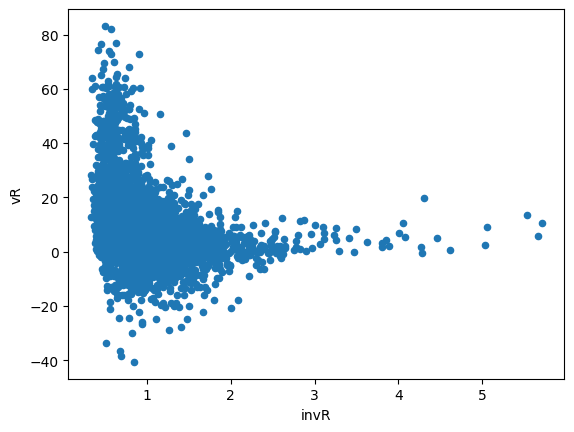

In [450]:
groups=df_dRdt.groupby(by=['trial_num','annihilation_index'])
groups.median().plot.scatter(x='invR',y='vR')

In [ ]:
# for n in [name_lst[5]]:
#     g = groups.get_group(n)
# g

In [393]:
# df_ranges['aR'].isnull().all()

True

In [392]:
# df_ranges.loc[gg.index.values]

In [451]:
# #compute smoothed derivatives
# # dd = gg #pd.DataFrame(dict_traj)
# df_ranges.iloc[gg.index]['xt'] = savgol_filter(gg['tdeath'],**savgol_kwargs0) #ms
# df_ranges.iloc[gg.index]['xR'] = savgol_filter(gg['R'],**savgol_kwargs0) #cm
# df_ranges.iloc[gg.index]['vR'] = savgol_filter(gg['R'],**savgol_kwargs1)*fps #cm per s
# df_ranges.iloc[gg.index]['aR'] = savgol_filter(gg['R'],**savgol_kwargs2)*fps**2 #cm per s^2
# # #test that smoothing has no effect on time
# # assert np.isclose(dd['xt'].values-dd['tdeath'].values,0.).all()

In [452]:
# df_ranges.loc[gg.index]

In [369]:
# #compute smoothed derivatives
# dd = gg #pd.DataFrame(dict_traj)
# dd['xt'] = savgol_filter(dd['tdeath'],**savgol_kwargs0) #ms
# dd['xR'] = savgol_filter(dd['R'],**savgol_kwargs0) #cm
# dd['vR'] = savgol_filter(dd['R'],**savgol_kwargs1)*fps #cm per s
# dd['aR'] = savgol_filter(dd['R'],**savgol_kwargs2)*fps**2 #cm per s^2
# #test that smoothing has no effect on time
# assert np.isclose(dd['xt'].values-dd['tdeath'].values,0.).all()

In [300]:
# #estimated run time ~ 20 minutes for 20 trials
# #recall how many particles were considered and scale accordingly
# range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
# # range_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
# data_lst_all = load_from_pickle(range_dir)
# max_num_trials=20
# data_lst=[]
# for i in range(max_num_trials):
#     data_lst.append(data_lst_all[i])
# # # Initial call to print 0% progress
# num_steps=len(data_lst)
# printProgressBar(0, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
# trial_num_lst=[]
# annihilation_count_lst=[]
# traj_lst=[]
# for step,data in enumerate(data_lst):
#     pass

In [ ]:

# trial_num=np.max(data['trial_num'])
# trial_num_lst.append(trial_num)
# annihilation_count_lst.append(np.max(data['annihilation_index']))

# d = pd.DataFrame(data)#.sort_values(by='t')
# #extract trajectories of particle self
# for annihilation_index,g in d.groupby('annihilation_index'):
#     gg = g.sort_values('tdeath')
#     t_values=gg['tdeath']
#     x_values,y_values = unwrap_and_center_xy_values(gg['x'].values,gg['y'].values,width,height)#,**kwargs)
#     minlifetime=np.max(t_values)
#     if minlifetime>=min_minlifetime:
#         dict_traj=dict(trial_num=trial_num,
#                        particle=annihilation_index,
#                        t=t_values,
#                        x=x_values,
#                        y=y_values)
#         #compute smoothed derivatives
#         dd = pd.DataFrame(dict_traj)
#         dd['vx'] = savgol_filter(dd['x'],**savgol_kwargs1)/DT #pixels per ms
#         dd['vy'] = savgol_filter(dd['y'],**savgol_kwargs1)/DT #pixels per ms
#         dd['ax'] = savgol_filter(dd['x'],**savgol_kwargs2)/(DT**2) #pixels per ms^2
#         dd['ay'] = savgol_filter(dd['y'],**savgol_kwargs2)/(DT**2) #pixels per ms^2
#         #compute instantaneous period
#         dd['T']=2*np.pi*(dd['vx']**2+dd['vy']**2)/np.abs(dd['vx']*dd['ay'] - dd['vy']*dd['ax'])
#         dd['sq_vel']=dd['vx']**2+dd['vy']**2
#         T_values=dd['T'].values        
#         #record
#         traj_lst.append(dd[['trial_num','particle','t','T','sq_vel']].copy())
# printProgressBar(step + 1, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
# df_inst_period_fk = pd.concat(traj_lst)
# df_count_fk = pd.DataFrame(dict(trial_num=trial_num_lst,annihilation_count=annihilation_count_lst))
# #save df_inst_period_fk,lr as .csv
# inst_period_fk_dir="/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_inst_period_timeseries.csv"
# df_inst_period_fk.to_csv(inst_period_fk_dir,index=False)